## Installing dependencies

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


In [4]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)


In [5]:
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [6]:
dataset = raw_dataset.copy()

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [8]:
dataset = dataset.dropna()

In [9]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2:'Europe', 3: 'Japan'})

In [10]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

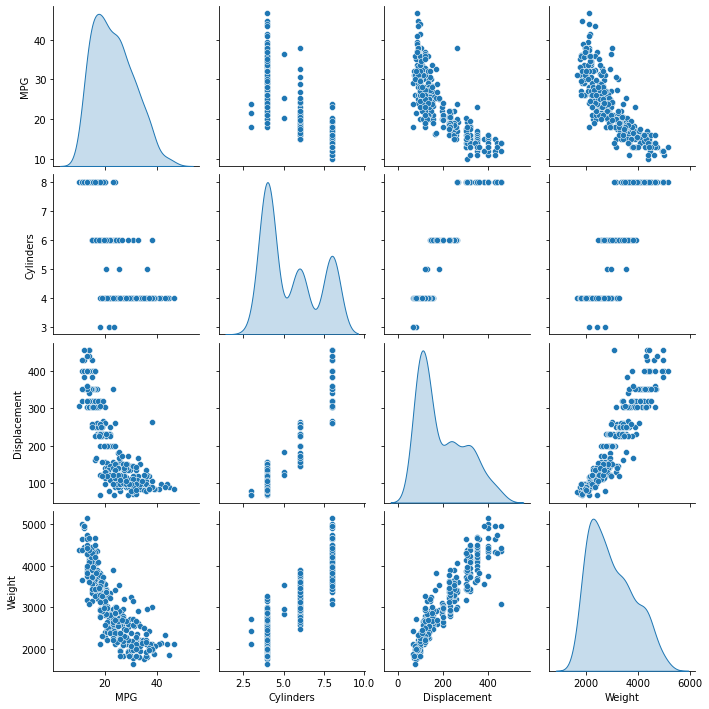

In [12]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [13]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [14]:
train_features = train_dataset.copy()
test_features = train_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [15]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [18]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization(axis=-1)


In [19]:
normalizer.adapt(np.array(train_features))

In [20]:
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [22]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('Fist example: ', first)
    print()
    print('Normalized', normalizer(first).numpy())
    

Fist example:  [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [23]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = tf.keras.layers.experimental.preprocessing.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

In [30]:
%%time
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])
horsepower_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
        loss='mean_absolute_error')

history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: total: 3.28 s
Wall time: 2.97 s


In [27]:
horsepower_model.predict(horsepower[:10])

array([[ 1.154],
       [ 0.652],
       [-2.129],
       [ 1.617],
       [ 1.463],
       [ 0.574],
       [ 1.733],
       [ 1.463],
       [ 0.381],
       [ 0.652]], dtype=float32)

In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802677,4.200730,95
96,3.804162,4.197897,96
97,3.805575,4.189818,97
98,3.803407,4.200546,98
99,3.802730,4.190460,99


In [35]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

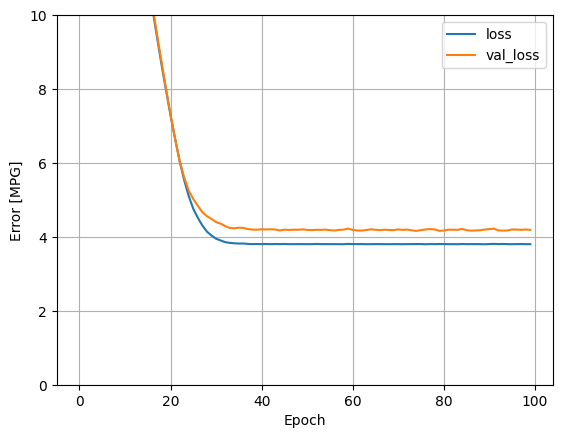

In [36]:
plot_loss(history)

In [37]:
test_results = {}

test_results['horespower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

In [38]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [39]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

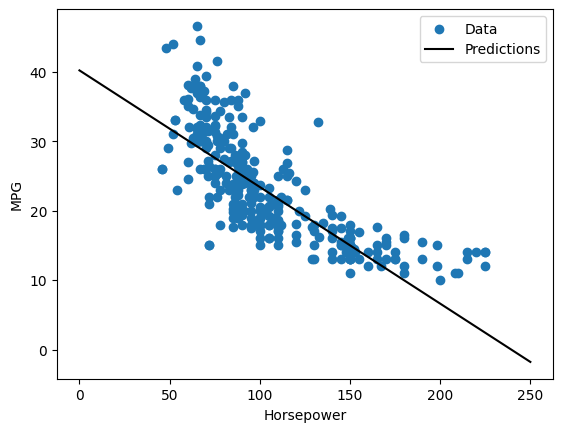

In [40]:
plot_horsepower(x, y)

In [44]:
%%time
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: total: 3.2 s
Wall time: 2.81 s


In [45]:
linear_model.predict(train_features[:10])

array([[26.052],
       [24.592],
       [12.115],
       [31.094],
       [32.387],
       [22.306],
       [33.083],
       [24.903],
       [20.447],
       [26.681]], dtype=float32)

In [46]:
linear_model.layers[1].kernel

<tf.Variable 'dense_5/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.315],
       [-0.052],
       [-1.414],
       [-3.274],
       [-0.891],
       [ 2.141],
       [-0.114],
       [ 0.657],
       [-1.011]], dtype=float32)>

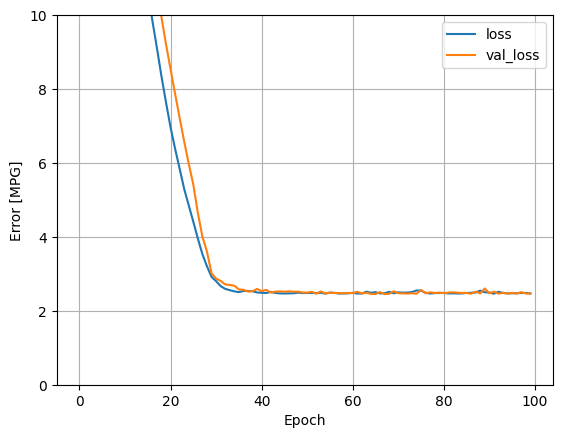

In [47]:
plot_loss(history)

In [48]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [57]:
%%time
def build_and_compile_model(norm):
    model = tf.keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                 optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

CPU times: total: 0 ns
Wall time: 0 ns


In [58]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [56]:
dnn_horsepower_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [60]:
history = dnn_horsepower_model.fit(
        train_features['Horsepower'],
        train_labels,
        validation_split=0.2,
        verbose=0, epochs=100)

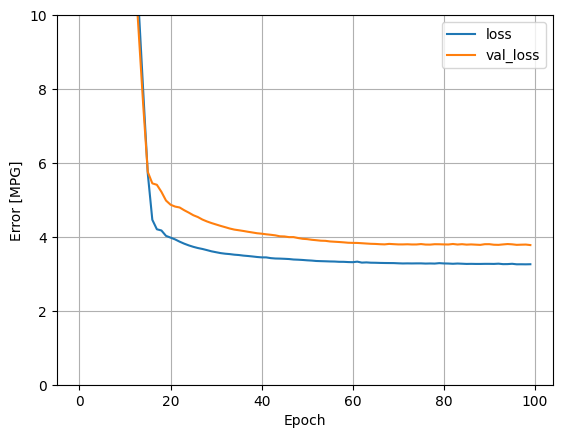

In [61]:
plot_loss(history)

In [62]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

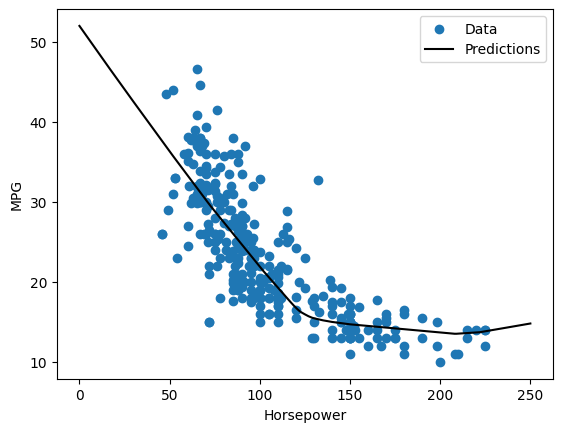

In [63]:
plot_horsepower(x, y)

In [64]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

In [67]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_18 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [69]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 22.6 s
Wall time: 4.09 s


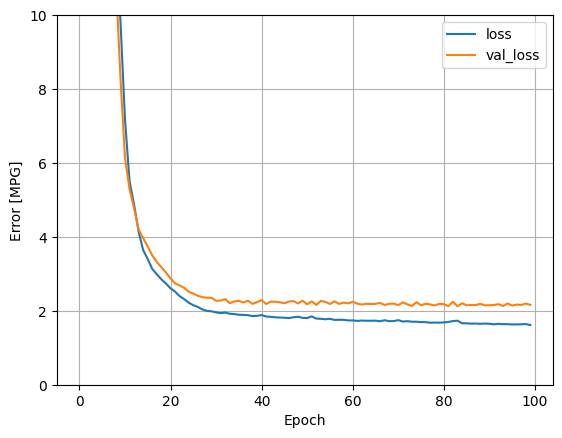

In [70]:
plot_loss(history)

In [71]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels,verbose=0)

In [72]:
pd.DataFrame(test_results, index=["Mean Absolute error [MPG]"]).T

,Mean Absolute error [MPG]
horespower_model,3.879203
linear_model,2.461547
dnn_horsepower_model,3.359090
dnn_model,1.721853


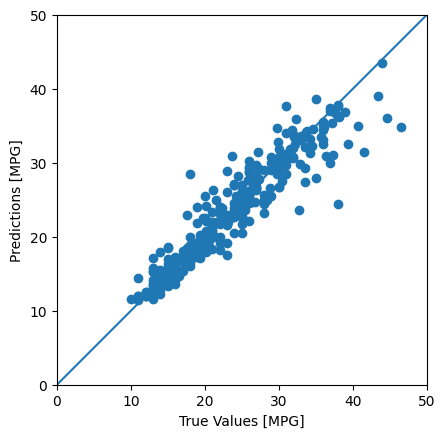

In [73]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

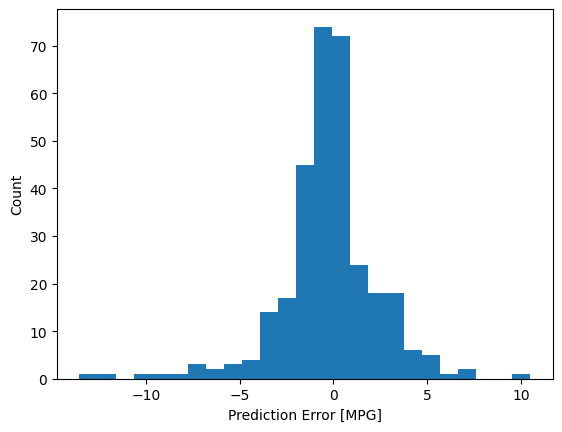

In [74]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [75]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [76]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horespower_model,3.879203
linear_model,2.461547
dnn_horsepower_model,3.359090
dnn_model,1.721853
reloaded,1.721853
